# Visualize the cross-correlation response map for synthetic images
- Author: Yong Lee (yongli.cv@gmail.com)
- Date: Sep 1st, 2021

/home/yong/miniconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  del sys.path[0]
/home/yong/miniconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


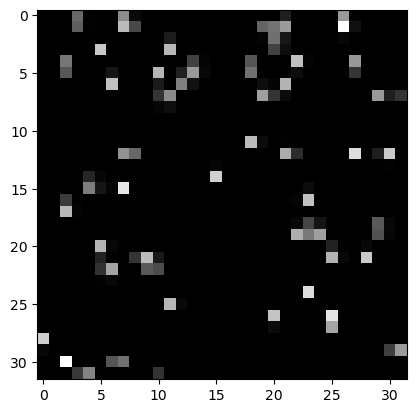

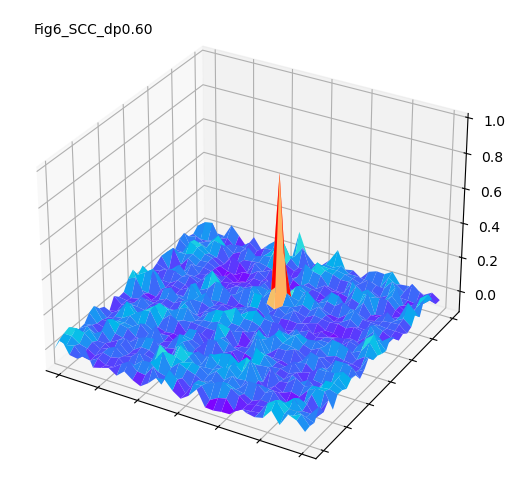

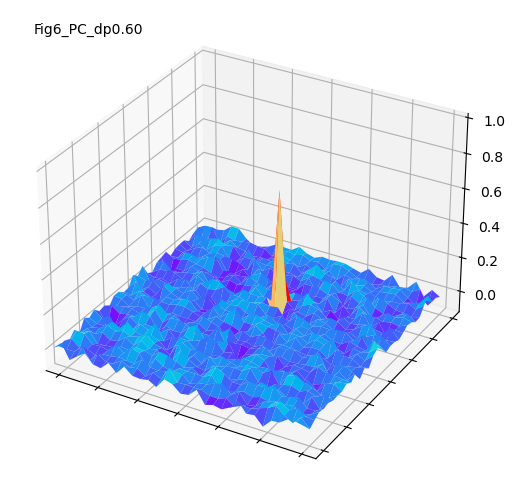

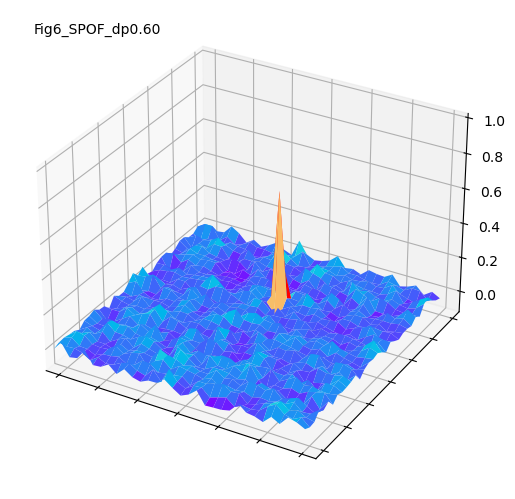

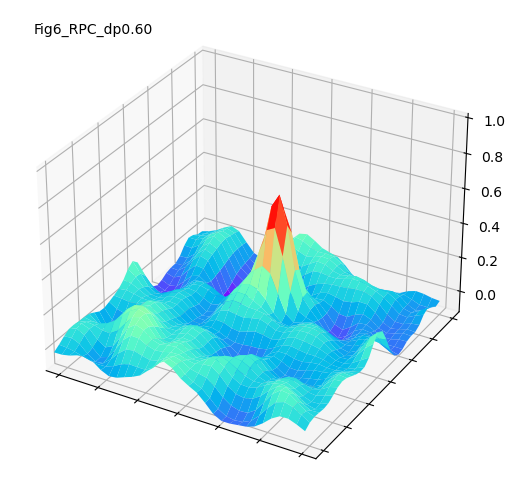

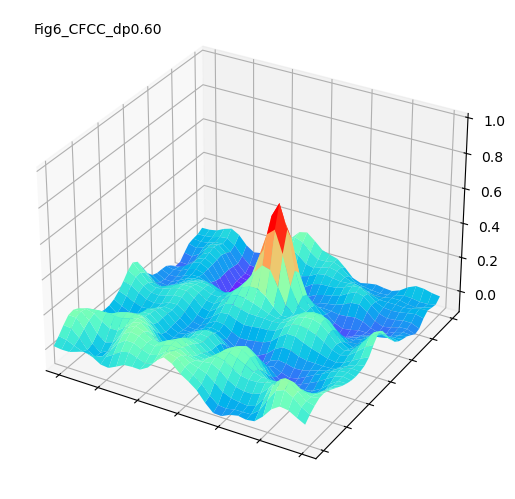

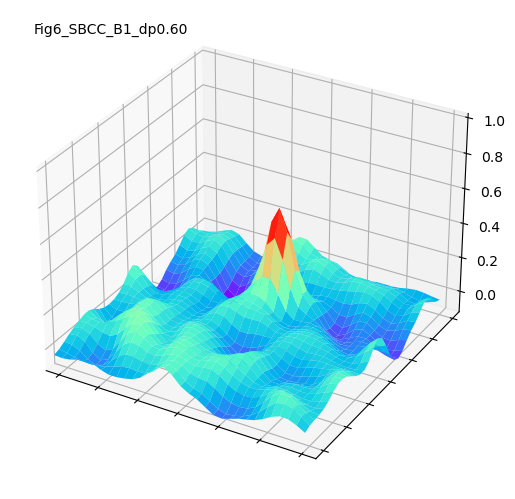

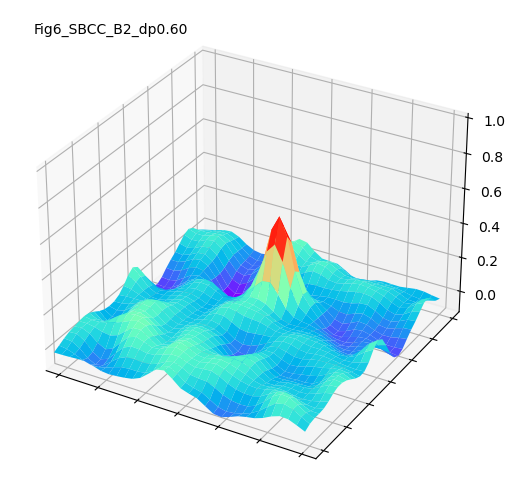

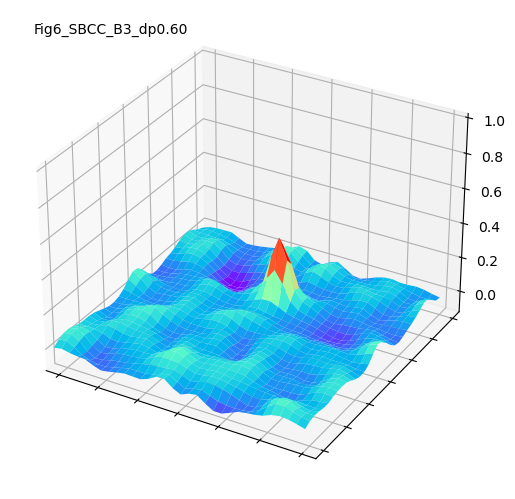

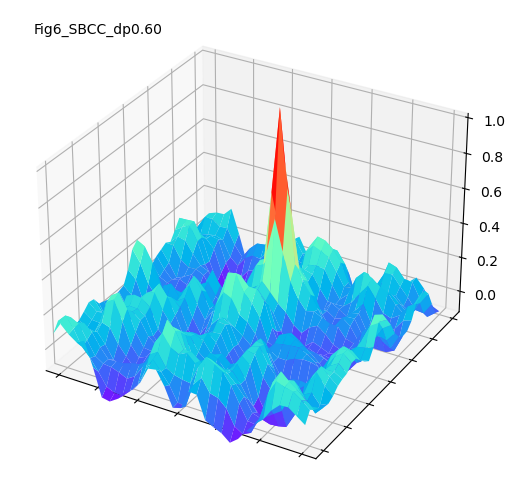

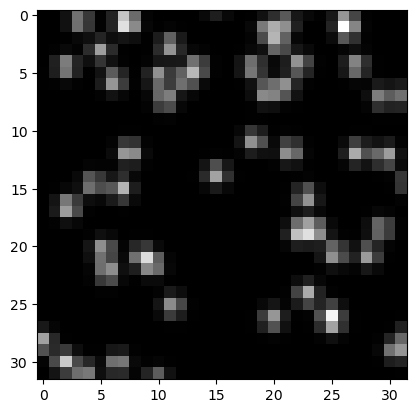

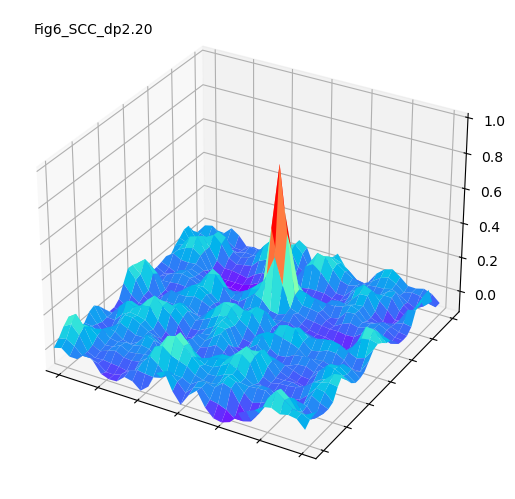

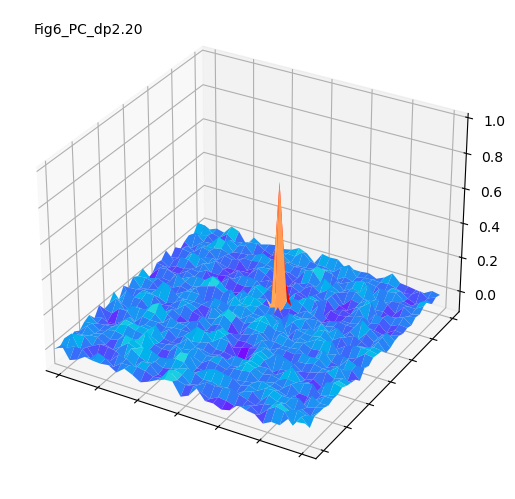

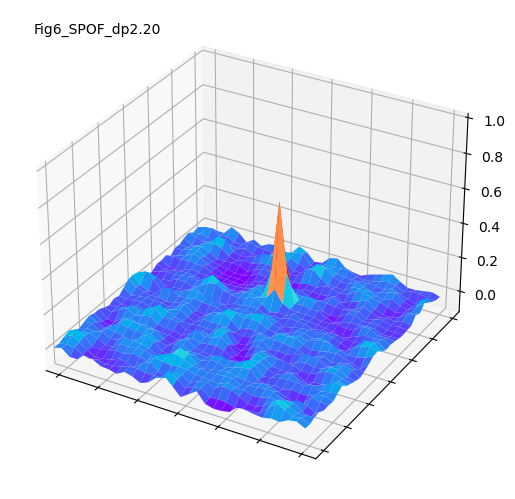

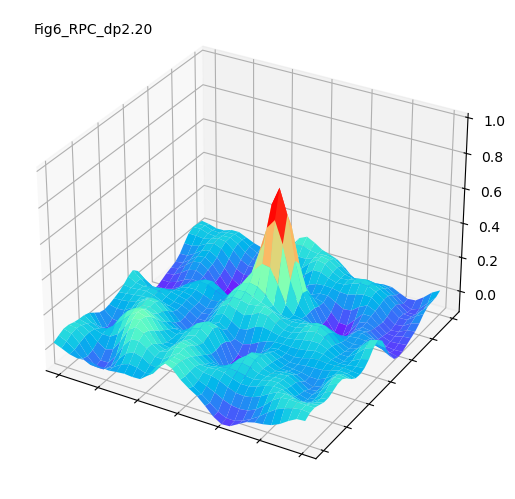

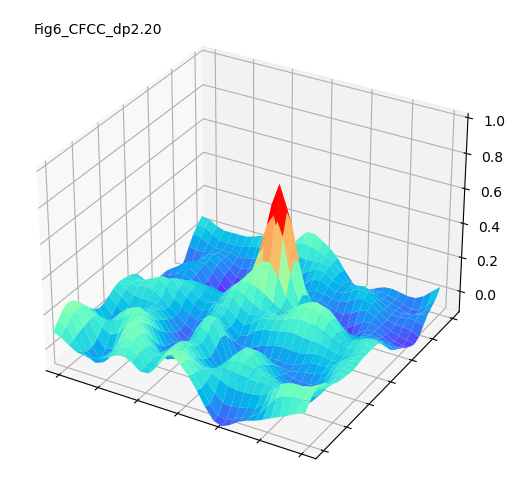

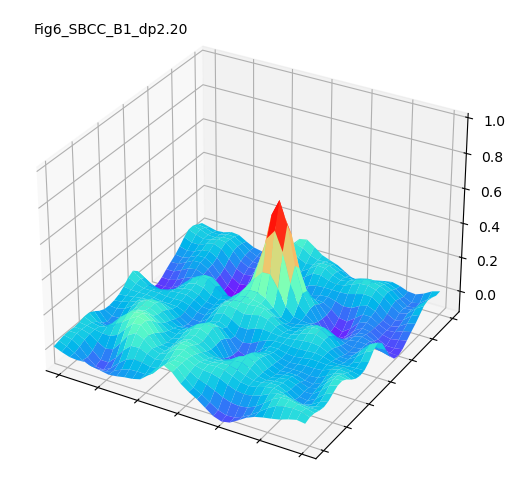

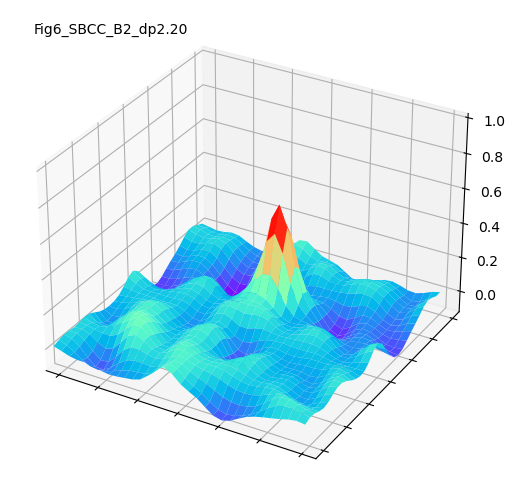

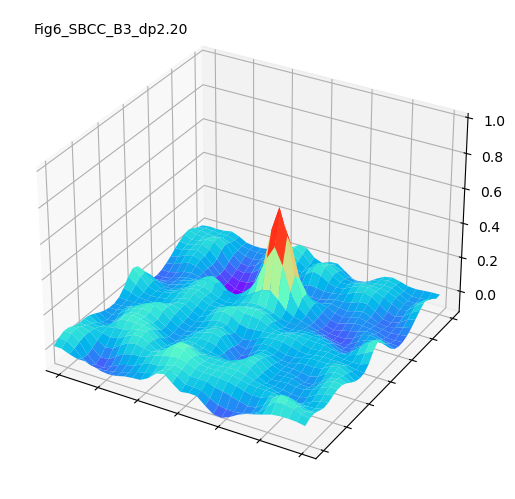

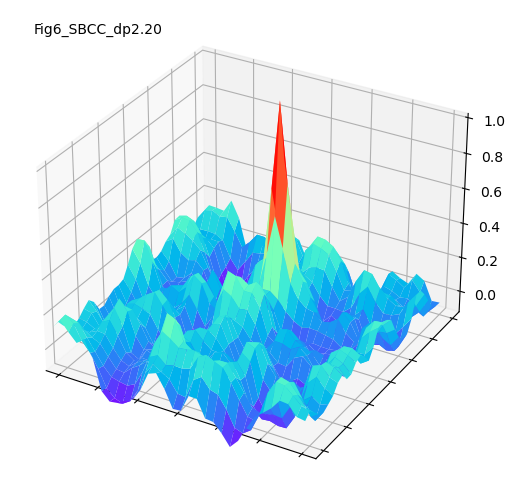

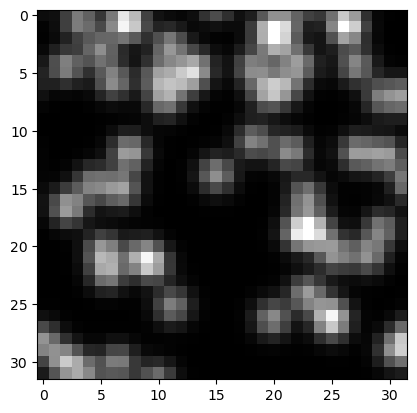

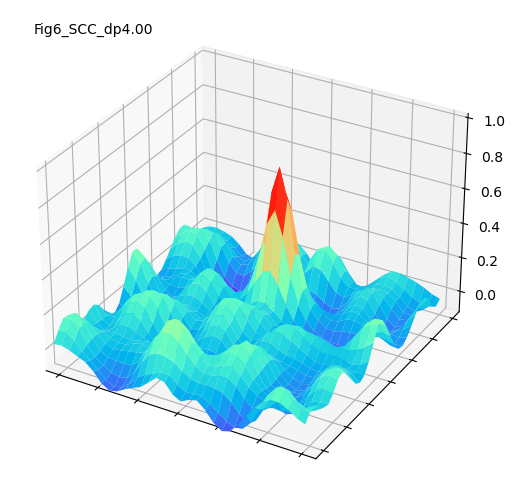

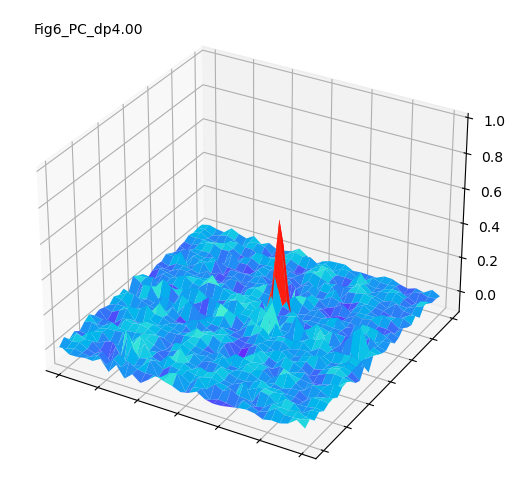

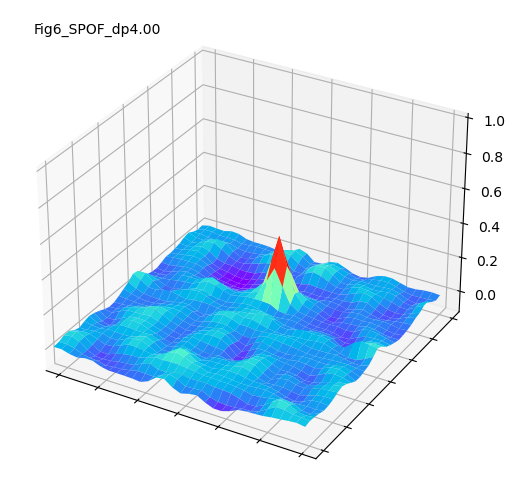

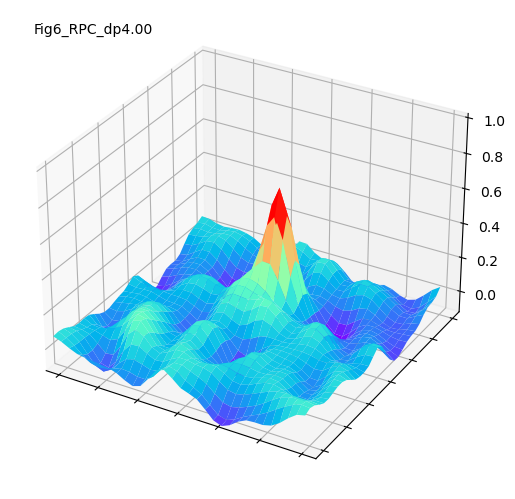

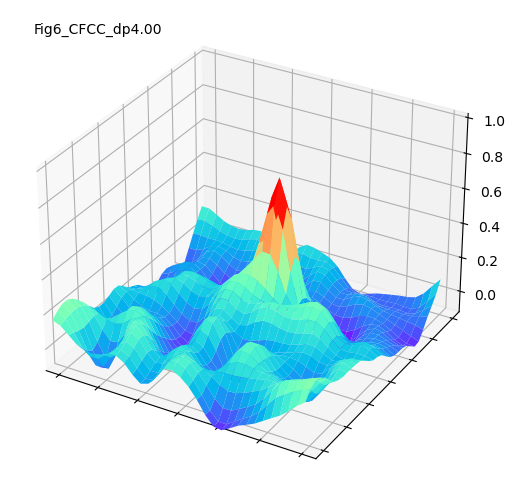

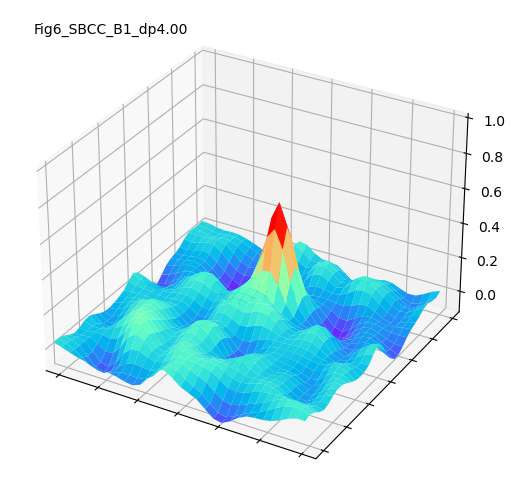

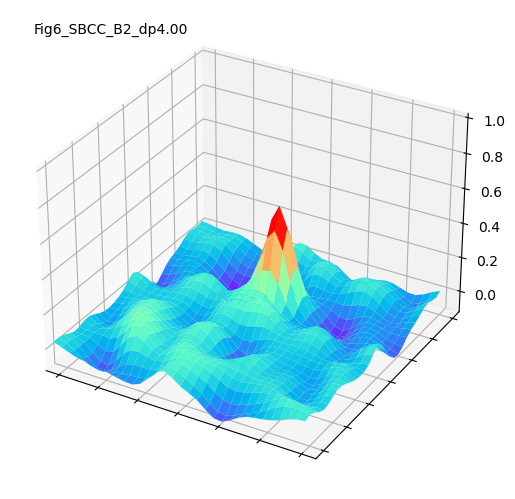

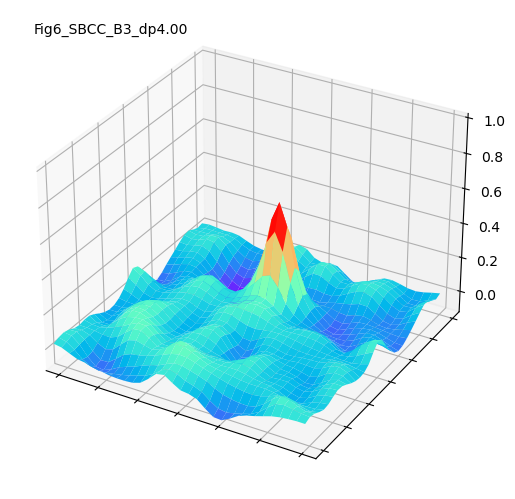

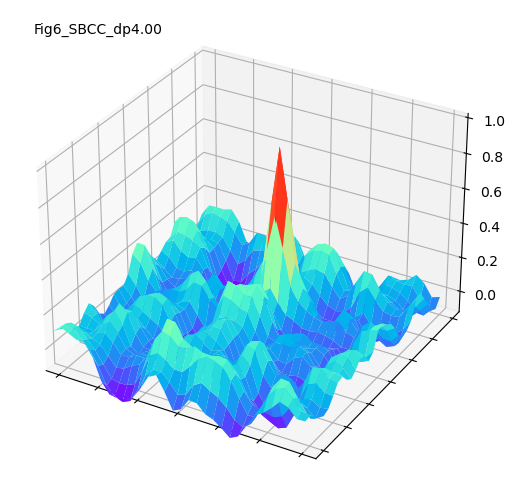

In [1]:
import numpy as np
import cv2
from utils.cc import scc, pc, spof, rpc, cfcc, sbcc, sbcc_b1, sbcc_b2, sbcc_b3
from piv import PIV
from data import gen_image_pair
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import tool
import os

def plot_cc_map(r, title):
    fig = plt.figure()
    ax = Axes3D(fig)
    x, y = np.meshgrid(np.arange(0,r.shape[0],1), np.arange(0,r.shape[0],1))
    x, y = x-r.shape[0]//2, y- r.shape[1]//2
    ax.plot_surface(x[:],y[:],r[:], cmap='rainbow')
    ax.set_zlim(-0.1,1.0)
    ax.set_xlim(-16,16)
    ax.set_ylim(-16,16)
    ax.text2D(0.05, 0.95, title, transform=ax.transAxes) # comment this for a clean output
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def preprocessing(win):
    win=win- np.mean(win, axis=(0,1), keepdims=True)
    win=win/(np.linalg.norm(win, axis=(0,1), keepdims=True)+1e-8)
    return win

def main():
    methods = ['scc', 'pc', 'spof', 'rpc', 'cfcc', 'sbcc_b1', 'sbcc_b2', 'sbcc_b3', 'sbcc'] 
    dp_list = [0.6, 2.2, 4]
    
    # config for piv 
    conf_piv = tool.AttrDict()
    conf_piv.win_sz = [132,132]
    conf_piv.step_sz =[2,2]
    conf_piv.subpixel='gaussian' # 'centroid' # 'parabolic'

    # config for particle image generator (PIG)
    conf_pig = tool.AttrDict()
    conf_pig.img_sz = (32,32)
    conf_pig.ppp = 0.05
    # conf_pig.dp = 2.2
    conf_pig.d_std = 0.0
    conf_pig.i_std =0.1
    conf_pig.miss_ratio = 0.1
    conf_pig.displacement = 5.25


    for dp in dp_list :
        np.random.seed(20210401) # fix the random seed 
        conf_pig.dp = dp
        image1, image2 = [],[]
        for i in range(2): # Multiple interrogation windows are need, so we set the batch size as 2.
            img1, img2 = gen_image_pair(conf_pig)
            image1.append(img1)
            image2.append(img2)
        # cv2.imwrite('output/Fig6_'+str(dp)+'_1.png',image1[0])
        # cv2.imwrite('output/Fig6_'+str(dp)+'_2.png',image2[0])
        fig = plt.figure()
        plt.imshow(image1[0],cmap='gray')
        plt.savefig('output/Fig6_'+str(dp)+'_1.svg')
        
        image1  = np.stack(image1, axis=-1)
        image2  = np.stack(image2, axis=-1)
        image1, image2 = preprocessing(image1), preprocessing(image2)

        for method in methods:
            r = eval(method)(image1, image2)
            info = f"Fig6_{method.upper()}_dp{dp:.2f}"
            fig = plot_cc_map(r[:,:,0], info)
            plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
            pdf_path = 'output/'+info +".pdf"
            svg_path = 'output/'+info +".svg"
            # plt.savefig(pdf_path, bbox_inches='tight') # the plt.save has bugs to save as pdf
            plt.savefig(svg_path)
            os.system(f"inkscape {svg_path} --export-pdf={pdf_path}")
            os.system(f"pdfcrop {pdf_path} {pdf_path}")
    plt.show()

main()